## Introduction
This notebook uses a bag of words model to analyze the words that most commonly appear among the tweets scraped from the Steelers' Wildcard loss to the Chiefs/Big Ben's final game.   

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction import text
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
import spacy
from spacy.lang.en.stop_words import STOP_WORDS as en_stop
from wordcloud import WordCloud
from nltk.probability import FreqDist
import re

In [2]:
df = pd.read_pickle("game_df_clean.pkl")

## 1. Words Most Commonly Used in the Entire Dataset (not including the obvious)

In [3]:
#Create list of stop words 
stop_words = list(en_stop) + ['Pittsburgh', 'pittsburgh',"Steelers", "playoffs","de","going","got","team","today",
                              "steelers", "like","says", "qb", "ll","ve", 'Chiefs',"chiefs",'tonight',"fan",
                              "game", "gets", "said", "play","nfl","playoff", "let","vs","don","need","que","gonna","getting",
                             "seeing","los", "wins", "Kansas","kansas", "city", "nd"]

#Create a document term matrix for the entire data set based upon the cleaned texts (including bigrams)
cv = CountVectorizer(stop_words=stop_words, 
                     max_df=.8,
                     min_df=5,
                     ngram_range=(1,2))
df_cv = cv.fit_transform(df.sentiment_text)
dtm_gen = pd.DataFrame(df_cv.toarray(), columns=cv.get_feature_names_out())
dtm_gen.index = df.user
dtm_gen =dtm_gen.groupby('user').sum().T

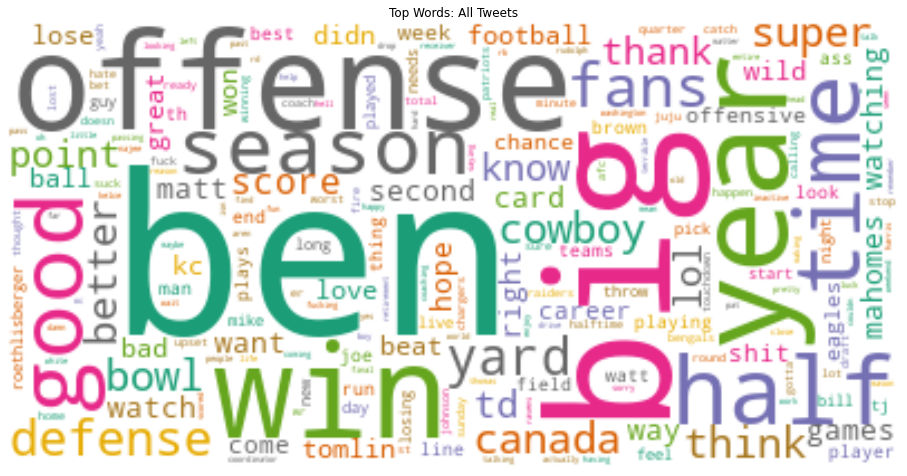

<Figure size 1152x1440 with 0 Axes>

In [4]:
#Create dictionary of words for all users
word_dict = {}
for user in dtm_gen.columns:
    dtm =dtm_gen[dtm_gen[user] !=0] #ignore words they don't use 
    dtm = dtm[user]
    word_dict[user]= list(zip(dtm.index, dtm.values))

#Identify the words used    
words = []
for user in dtm_gen.columns:
    top1= [word for (word, count) in word_dict[user]]
    for w in top1:
        words.append(w)
        
#Join them into a string that we can input into a wordcloud 
text = ','.join(word for word in words)


#Create wordcloud 
plt.rcParams['figure.figsize'] = [16, 20]
wc = WordCloud(stopwords=stop_words, 
               normalize_plurals=True, 
               background_color="white", 
               colormap="Dark2",
               collocations=False,
              max_font_size=100, 
               random_state=0)
wc.generate(text) 
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.title('Top Words: All Tweets')
    
plt.show() 
plt.savefig('TopWordsAllTweets.png') 

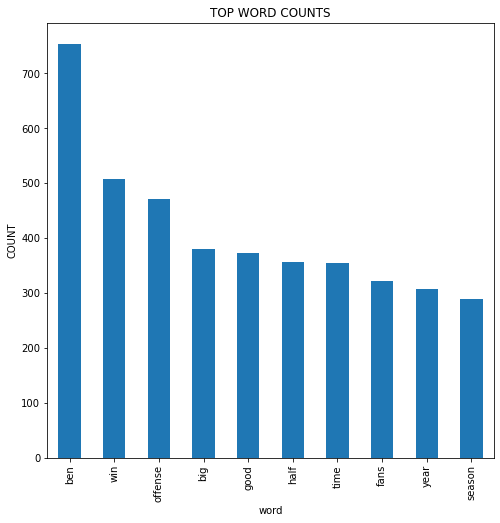

In [5]:
plt.rcParams['figure.figsize'] = [8, 8]
gen_counter = Counter(words).most_common()
most_common_words= pd.DataFrame(gen_counter, columns = ["word", "occurrences"]).set_index("word")
most_common_words.head(10).plot.bar(ylabel="COUNT", legend=False, title="TOP WORD COUNTS");

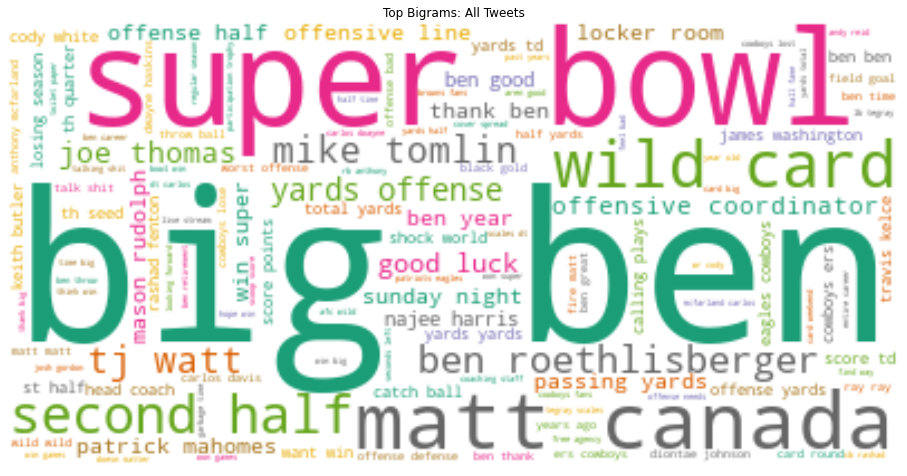

<Figure size 1152x1440 with 0 Axes>

In [6]:
#Repeat the process only looking at bigrams

#Create a document term matrix for the entire data exclusvely of bigrams
cv2 = CountVectorizer(stop_words=stop_words, 
                      max_df=.8, 
                      min_df=5, 
                      ngram_range=(2,2))
df_cv2 = cv2.fit_transform(df.sentiment_text)
dtm_gen = pd.DataFrame(df_cv2.toarray(), columns=cv2.get_feature_names_out())
dtm_gen.index = df.user
dtm_gen =dtm_gen.groupby('user', axis=0).sum().T

#Create dictionary of words for all users
word_dict_bigrams = {}
for user in dtm_gen.columns:
    dtm =dtm_gen[dtm_gen[user] !=0] #ignore words they don't use 
    dtm = dtm[user]
    word_dict_bigrams[user]= list(zip(dtm.index, dtm.values))

#Identify the words used    
bigrams = []
for user in dtm_gen.columns:
    top1 = [word for (word, count) in word_dict_bigrams[user]]
    for w in top1:
        bigrams.append(w)
        
#Join them into a string that we can input into a wordcloud 
text = ','.join(word for word in bigrams)


#Create wordcloud 
plt.rcParams['figure.figsize'] = [16, 20]
wc2 = WordCloud(stopwords=stop_words, 
               normalize_plurals=True, 
               background_color="white", 
               colormap="Dark2",
               collocation_threshold = 3,
               max_font_size=100, 
               random_state=0)
wc2.generate(text) 
plt.imshow(wc2, interpolation="bilinear")
plt.axis("off")
plt.title('Top Bigrams: All Tweets')
    
plt.show() 
plt.savefig('TopBigrams.png') 

In [7]:
gen_counter = Counter(bigrams).most_common()
most_common_bigrams= pd.DataFrame(gen_counter, columns = ["bigrams", "occurrences"]).set_index("bigrams")
most_common_bigrams.head(10)

,occurrences
bigrams,
big ben,270
super bowl,118
matt canada,102
wild card,86
second half,78
ben roethlisberger,56
tj watt,50
mike tomlin,48
joe thomas,30


#### Observations: 
Ben Roethlisberger, the super bowl, and the offense are referenced most in individual words and bigrams. The focus upon Ben is likely because of his impending retirement and the Steelers' notable offensive struggles throughout the game (and season). Understandably, Matt Canada (the offensive coordinator) is also mentioned quite a bit, because fans question his play calling/design. 

## 2. Top Ten Tweeters and their Word Usage

In [8]:
#Find top 10 tweeters and #of tweets
top_ten = df.groupby('user').size().sort_values(ascending=False)[0:10]
top_ten = pd.DataFrame(top_ten, columns=['num_tweets'])
top_users = top_ten.index
top_ten

,num_tweets
user,
Steelersdepot,40
Blitz_Burgh,18
Bad2thebonezz,14
LarryMo36637577,13
NehlsStan,10
ryanwilliamsCLE,10
BrioniBoy12,10
butch95472079,10
JHartman_PIT,9


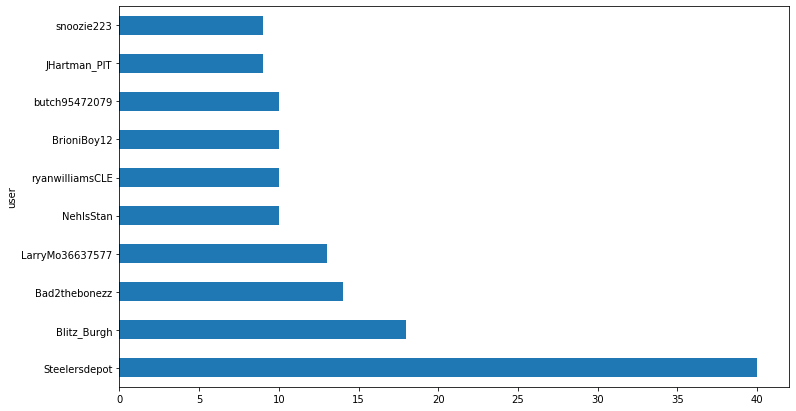

In [9]:
top_ten['num_tweets'].sort_values(ascending=False).plot(kind='barh', figsize= (12,7));

#### Observation:
The top tweeter throughout the entire sample time span is Steelersdepot, which is affiliated with a Steelers news blog. Most of the other top tweeters are individual fans (not necessarily of the Steelers). One of them is a trolling fan of the Chiefs.

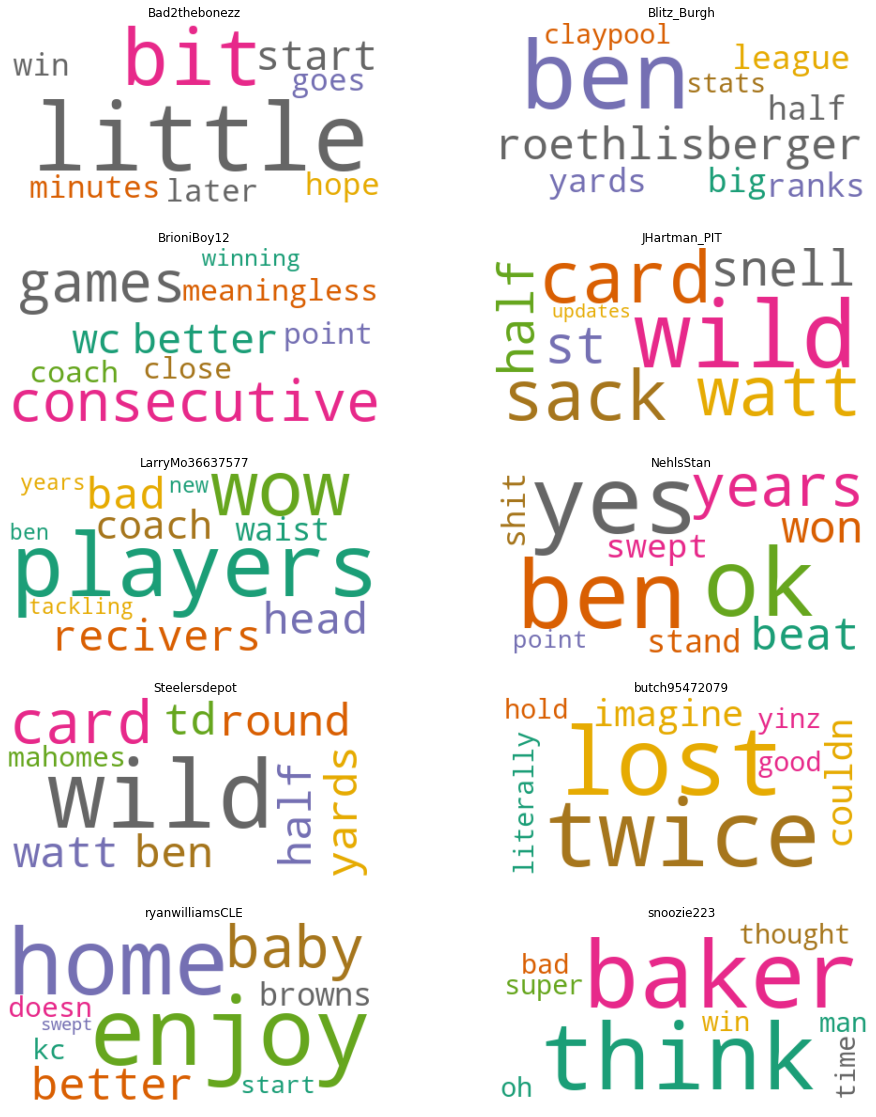

In [10]:
#Top words for Each Top Tweeter
top_ten_df = df[df['user'].isin(top_users)]

#Create document term matrix for the top ten tweeters
cv3 = CountVectorizer(stop_words=stop_words, 
                      max_df=.85, 
                      min_df=2, 
                      ngram_range=(1,2))
df_cv3 = cv3.fit_transform(top_ten_df.sentiment_text)
dtm_ten = pd.DataFrame(df_cv3.toarray(), columns=cv3.get_feature_names_out())
dtm_ten.index = top_ten_df.user
dtm_ten =dtm_ten.groupby('user', axis=0).sum().T

# Find the top 10 words said by each user
top_dict_ten = {}
for user in dtm_ten.columns:
    dtm =dtm_ten[dtm_ten[user] !=0] #ignore words they don't use
    top = dtm[user].sort_values(ascending=False).head(10)
    top_dict_ten[user]= list(zip(top.index, top.values))

#Plot wordclouds for each user and display them  
wc3 = WordCloud(stopwords=stop_words, 
                normalize_plurals=True, 
                background_color="white", 
                colormap="Dark2",
                max_font_size=100, 
                random_state=0)

i=1
for key in top_dict_ten.keys():
    text = ' '.join(word for word,count in top_dict_ten[key])
    wc3.generate(text) 
    plt.subplot(5, 2, i)
    plt.imshow(wc3, interpolation="bilinear")
    plt.axis("off")
    plt.title(key)
    plt.savefig('TopTenTweetersCloud.png')
    i +=1

plt.show();

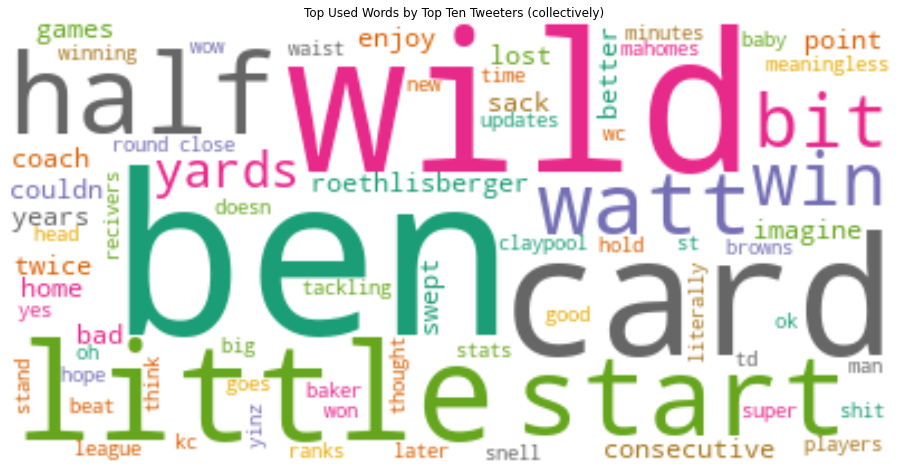

<Figure size 1152x1440 with 0 Axes>

In [11]:
# Word cloud of the Words Most Commonly Used by the Top Ten (collectively)

ten_words = []
for user in dtm_ten.columns:
    top = [str(word) for (word, count) in top_dict_ten[user]]
    for w in top:
        ten_words.append(w)

wc4 = WordCloud(stopwords=stop_words, 
                normalize_plurals=True, 
                background_color="white", 
                colormap="Dark2",
                max_font_size=100, 
                random_state=0)      

text = ','.join(ten_words)
wc4.generate(text) 
plt.imshow(wc4, interpolation="bilinear")
plt.axis("off")
plt.title('Top Used Words by Top Ten Tweeters (collectively)')
    
plt.show()
plt.savefig('TopWordsTopTenCloud.png') 

#### Observation:
Ben is mentioned most, in connection with the Steelers' lack of production on offense (slow start and lack of yards), which has been a big issue throughout the season. 

## 3. Hashtag usage

In [12]:
#Filter out rows without hash tags and drop rows with NaNs
df_tags= df.loc[df['hashtags'] != '']
df_tags= df_tags.loc[~df['hashtags'].str.contains('Steelers|steelers')]
df_tags.dropna(inplace=True)

#Find top ten most commonly tweeted hash tags
top_tags= df_tags.hashtags.value_counts().head(10)
most_common_hashtags= pd.DataFrame(top_tags)
most_common_hashtags

,hashtags
HereWeGo,82
PITvsKC,55
ChiefsKingdom,18
joethomas73,17
Browns,12
7,11
NFL,10
Chiefs,9
_BigBen7,8
1,7


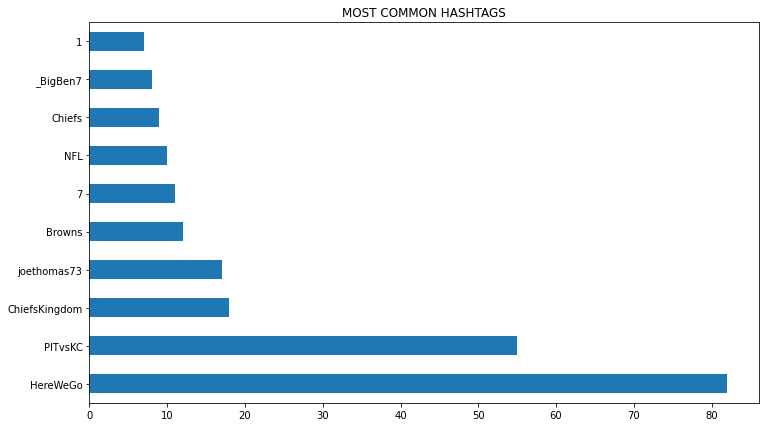

In [13]:
most_common_hashtags.plot(kind='barh', title="MOST COMMON HASHTAGS", figsize= (12,7), legend=False);

In [14]:
#Top Ten Most Frequent Taggers
top_taggers_df=df_tags.groupby(['user'])['hashtags'].count().sort_values(ascending=False)[0:10]
top_taggers_df = pd.DataFrame(top_taggers_df)
top_taggers = top_taggers_df.index
top_taggers_df

,hashtags
user,
TheDaleOrtiz,5
RichieWalsh,4
dr_jay23,3
TheGridironLS,3
NFLBadgers,3
Ramonco74353444,3
jasonbigmachine,2
jasonrohner,2
DaFreshPrince38,2


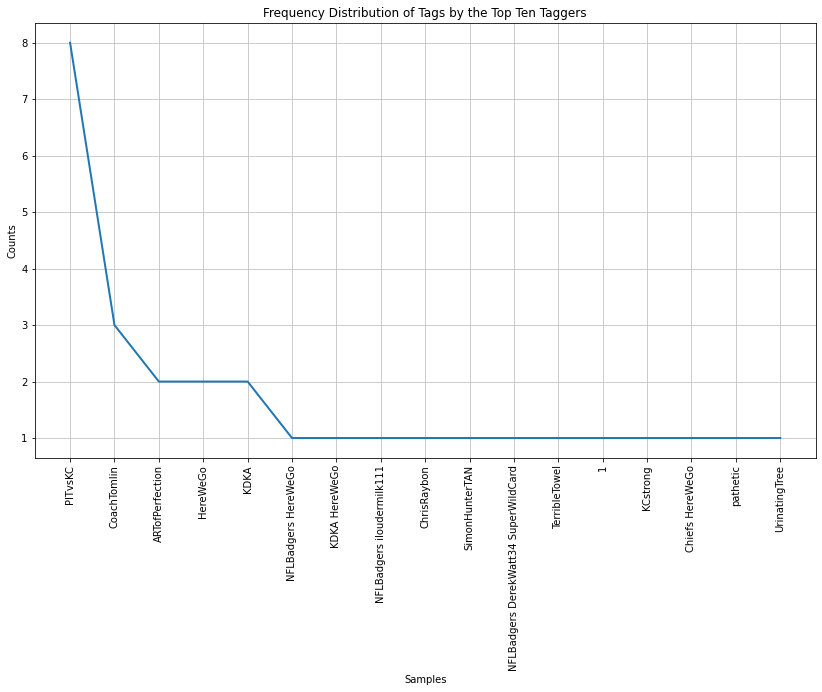

In [15]:
#df restricted to top ten taggers
taggers_df = df_tags[df_tags.user.isin(top_taggers)]

#Frequency Distribution of Top Taggers' Hashtags
plt.rcParams['figure.figsize'] = [14, 8]
FreqDist(taggers_df.hashtags).plot(title="Frequency Distribution of Tags by the Top Ten Taggers")
plt.show()

#### Observation:
Hashtags of the Steelers are the most frequent (unsurprisingly). So, I filtered them out. Not counting them, hashtags about the game (PITvsKC), Coach Tomlin, and the cheer that fans use to root for the Steelers ("Here We Go") are the most common.  

## 4. Tweets and Tags over Time

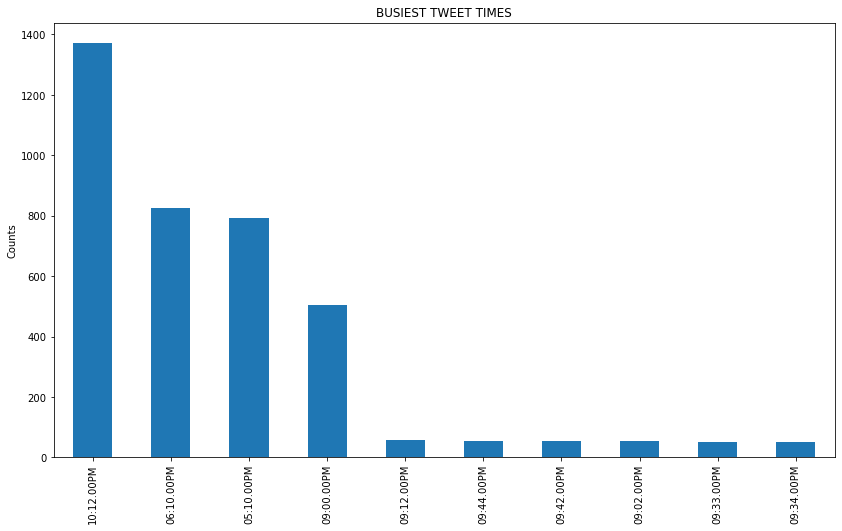

In [16]:
gen_times = df.time.value_counts().head(10)
gen_times_df = pd.DataFrame(gen_times)
gen_times_df.plot.bar(title = 'BUSIEST TWEET TIMES', ylabel="Counts", legend=False);

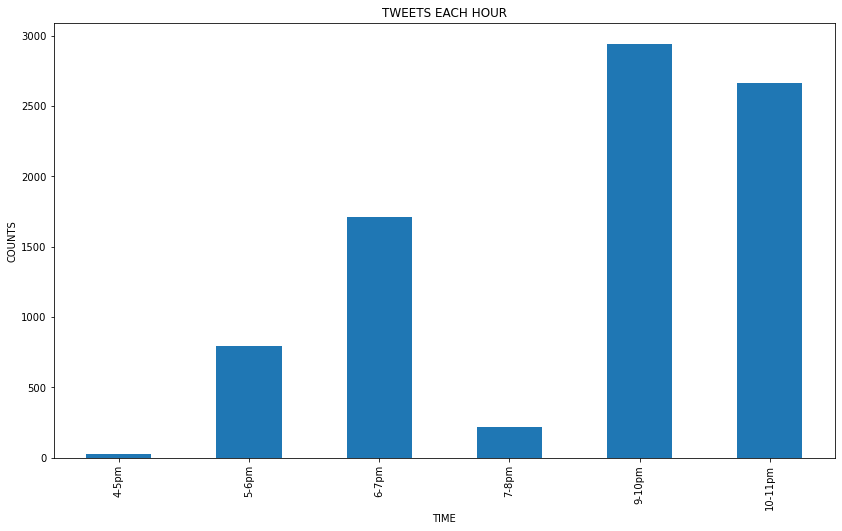

In [17]:
#create time bins for each hour and plot the distribution of tweets per hour 
#NOTE: the 8-9pm window is omitted because no data was collected for that time period

df_bins = df.copy()
df_bins['time'] = pd.to_datetime(df_bins['time'], format="%I:%M.%S%p")

bins = [16,17,18,19, 21,22,23]

labels = ['4-5pm','5-6pm','6-7pm','7-8pm','9-10pm','10-11pm']
df_bins['time_bin'] = pd.cut(df_bins.time.dt.hour,bins, labels=labels, right=False)
df_bins_plot = pd.DataFrame(df_bins.groupby('time_bin').size())

df_bins_plot.plot.bar(xlabel='TIME', 
                      ylabel='COUNTS', 
                      title= "TWEETS EACH HOUR", 
                      legend=False);

#### Observation:
10:12pm is the single time point with the most tweets. That is right around the start of the second half of the game. But the 9-11pm windows are the ones with the most tweets, which is understandable because they are the two windows during which the game took place. (No data was collected for the 8-9pm timespan, essentially the first quarter of the game.) Below I divide that two hour window into ten minute bins and plot the tweet counts.

C:\Users\karbo\anaconda3\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


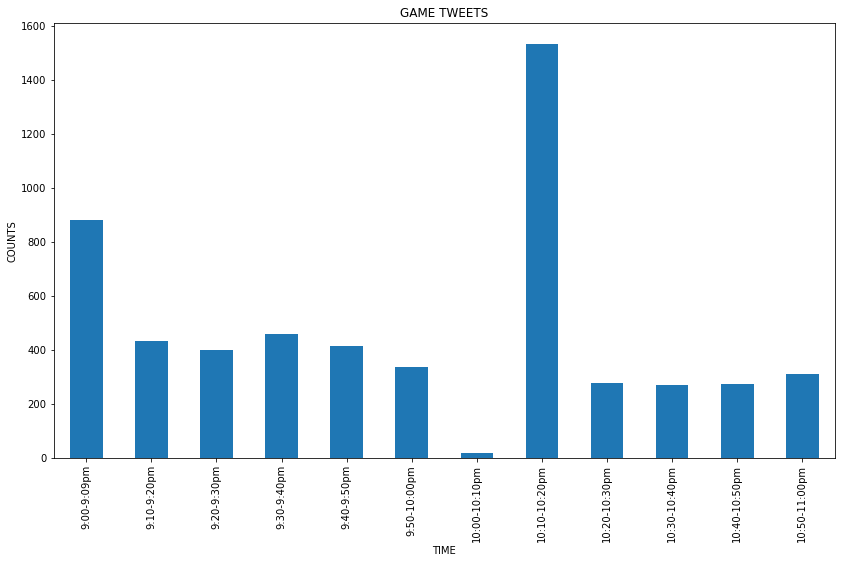

In [18]:
#Restrict focus to game 
df_gametime= df_bins[(df_bins['time_bin'] == '9-10pm') | (df_bins['time_bin'] =='10-11pm')]

#Create bins for (approximately) every ten minutes
labels= ['9:00-9:09pm', '9:10-9:20pm', '9:20-9:30pm', '9:30-9:40pm', '9:40-9:50pm', '9:50-10:00pm',
       '10:00-10:10pm', '10:10-10:20pm', '10:20-10:30pm', '10:30-10:40pm', '10:40-10:50pm', '10:50-11:00pm']

df_gametime.loc[:, 'time_bin2'] = pd.cut(df_gametime.loc[:, 'time'],labels=labels,bins=12,right=False)

df_gametime.groupby('time_bin2').size().plot.bar(xlabel='TIME',
                                                 ylabel='COUNTS',
                                                 title= "GAME TWEETS", 
                                                 legend=False);


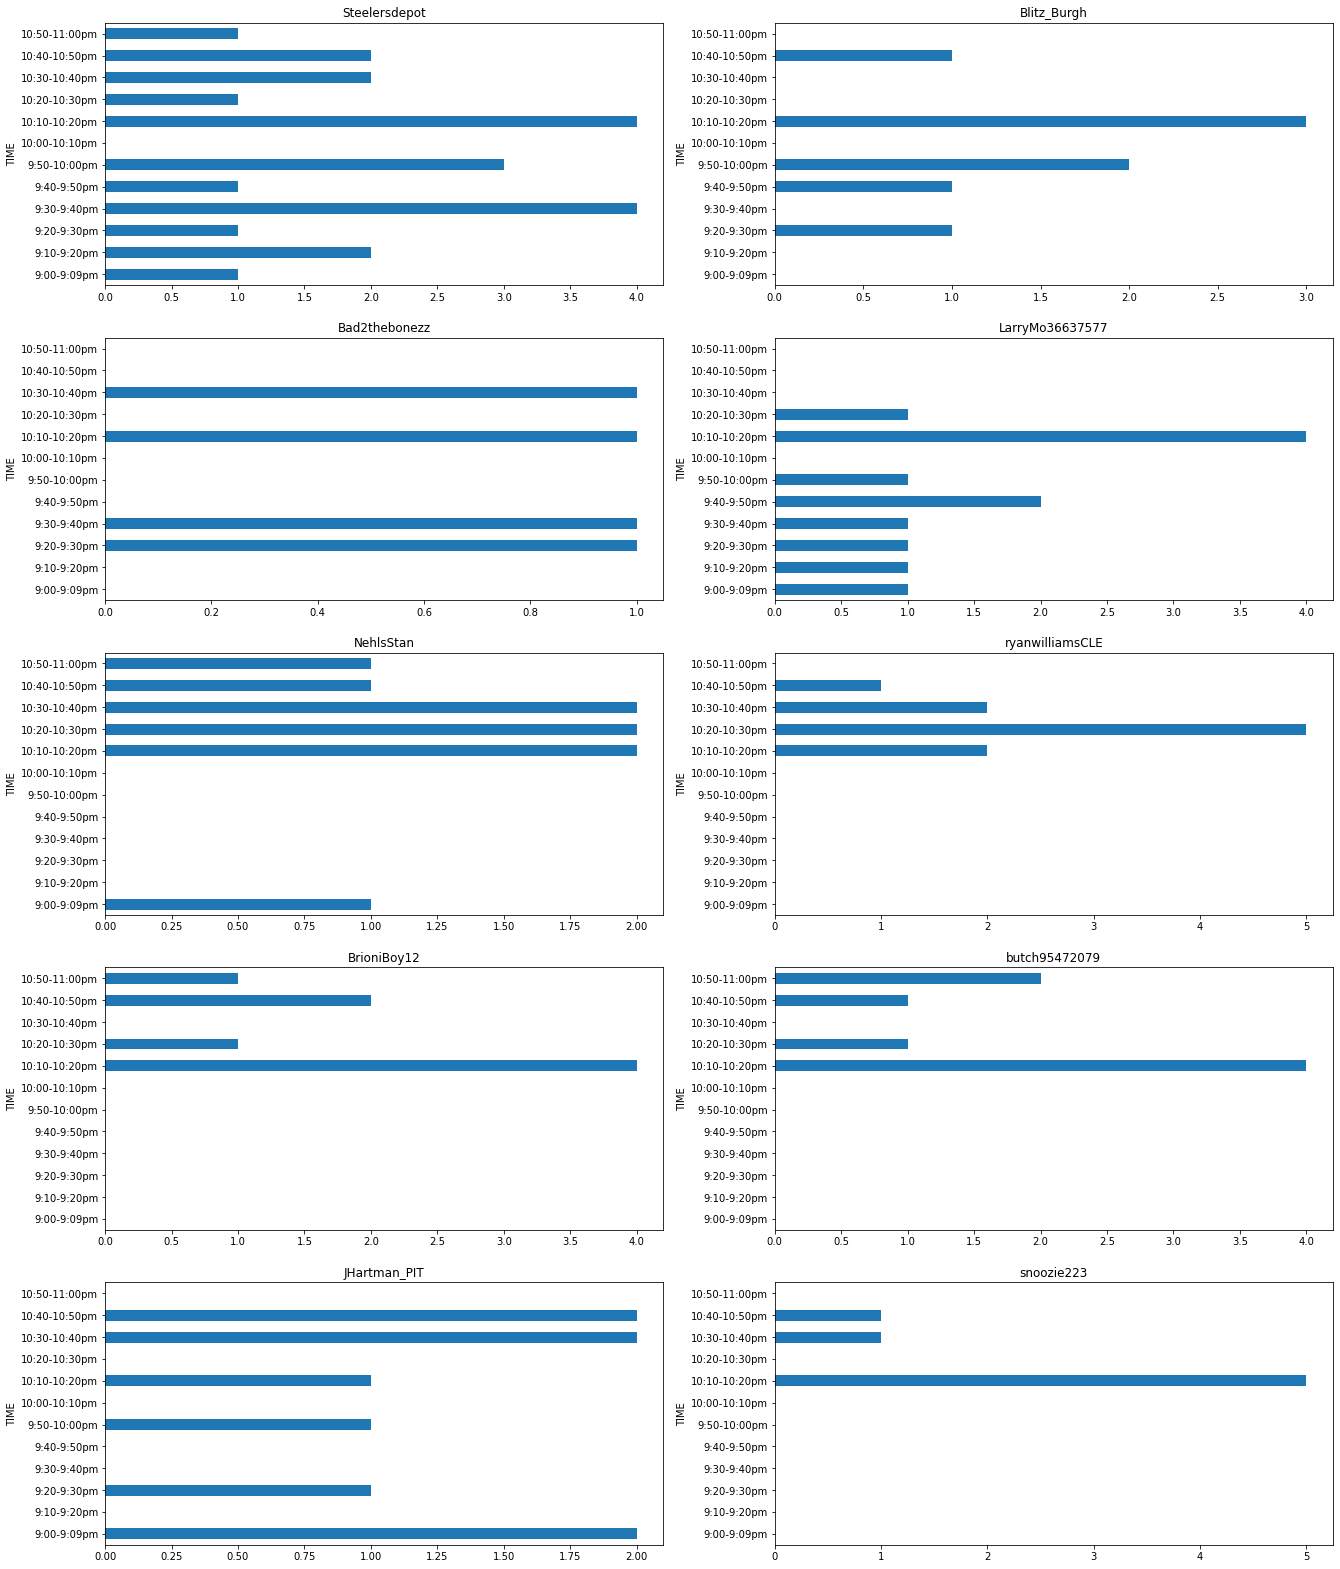

In [19]:
#Game Tweet Count of Top Ten Tweeters
plt.rcParams['figure.figsize'] = [22, 28]
i=1
for user in top_users:
    plt.subplot(5, 2, i)
    df_gametime[df_gametime['user']==user].groupby('time_bin2').size().plot.barh(ylim=(0,6),
                                                                                xlabel='TIME',
                                                                                legend=False)
    plt.title(user)
    plt.savefig('Gametweetstopten.png')
    i +=1
    
plt.show();



#### Observation: 
All of the top ten tweeters were very active around halftime/the start of the second half. 

## 5. Conclusions and Caveats

This analysis of word frequency among the sample of tweets scraped during the Steelers' Wildcard loss to the Chiefs suggests that Big Ben and the offense's (slow) performance were primarily on the minds of fans (at least those fans whose tweets were grabbed by my scraper). Some mention of T.J. Watt and the defense was made, but it is striking how the emphasis is primarily upon the offense. This betrays a tendency of Steelers fans to emphasize the negative and ignore the positive (the defense played extremely well for the first quarter, even scoring a touchdown).

These conclusions must be interpreted as restricted to the sample of tweets scraped--they may or may not be representative of the broader Steelers-watching/tweeting population. It is also worth noting that the unstructured bag of words approach adopted here has limitations, because it ignores word-order and other structural features of the tweets, thereby missing potentially valuable information. But it suffices for my current purposes, which is simply to get an initial sense of the sorts of things Steelers fans were tweeting about before/during the game.      